<a href="https://colab.research.google.com/github/jnramirezg/analisis_estructural/blob/main/codigo/04-ejemplo_2_cap_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **04. 10.12. Ejemplo 2: viga simplemente apoyada**

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Juan Nicolás Ramírez, <jnramirezg@unal.edu.co> | 2024-09-20 | Creando código|

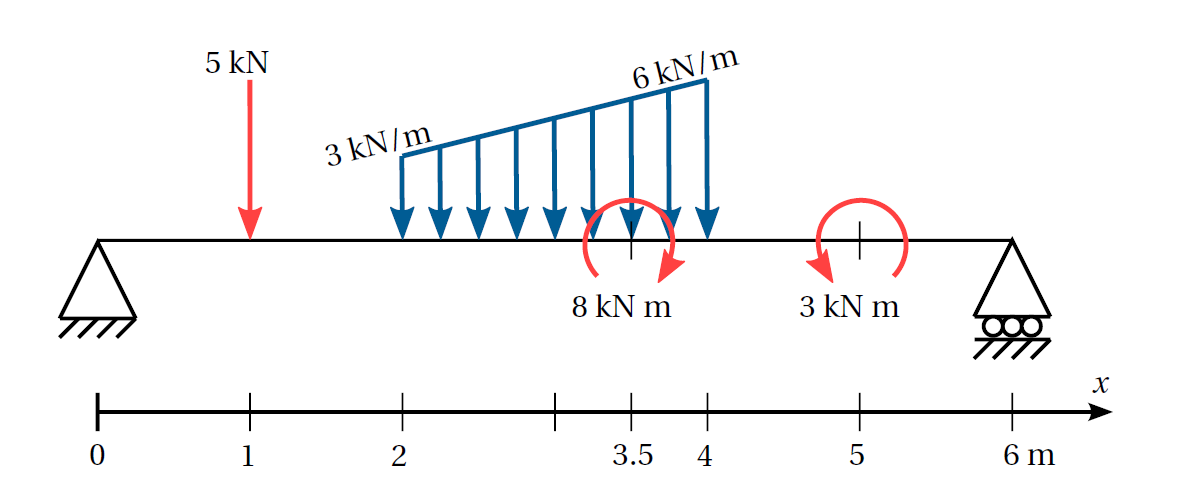

Consideremos la viga mostrada en la figura 10.22. Asumamos que dicha viga tiene una sección constante rectangular de $0.1m$ de base y $0.3m$ de altura y un módulo de elasticidad $E=210GPa$.

## Importar librerías y crear funciones

In [1]:
from sympy import lambdify, Piecewise, integrate, symbols, Eq, solve, diff
from numpy import sum, array, linspace, meshgrid, argmin, argmax
import matplotlib.pyplot as plt

In [2]:
# Función con la condición de Macaulay, a: punto de discontinuidad, g:grado
macaulay = lambda a, g : Piecewise(((x-a)**g, (a <= x)), (0, True))

In [3]:
def grafico_funcion_viga(x, f, titulo, momento=False):
    plt.figure(figsize=(10, 3))                   # Tamaño de la gráfica.
    plt.plot(x, f, 'r')                           # Gráfica de la función.
    plt.fill_between(x, f, color="lavenderblush") # Sombreado de la gráfica.
    plt.plot([0, max(x)], [0, 0], 'k')            # Eje x.
    plt.xlabel("Posición [m]")                   # Título del eje x.
    plt.ylabel(titulo)                            # Título del eje y.
    plt.xlim(0, max(x))                           # Límites en x del gráfico.
    if momento==True:             # Condición si la función es M(x).
        plt.gca().invert_yaxis()  # Invierte el eje y (función).
    plt.show()

def grafico_funcion_esfuerzo_seccion(y, f, titulo):
    plt.figure(figsize=(3, 6))                     # Tamaño de la gráfica.
    plt.plot(f, y, "r")                            # Gráfica de la función.
    plt.fill_betweenx(y,f, color="lavenderblush")  # Sombreado de la gráfica.
    plt.plot([0, 0], [min(y), max(y)], 'k')        # Eje y.
    plt.xlabel(titulo)                             # Título del eje x.
    plt.ylabel("Posición [m]")                    # Título del eje y.
    plt.ylim(min(yg), max(yg))                     # Límites en x del gráfico.
    plt.show()

def dibujar_esf_def(titulo, f, x, y):
    curvas = linspace(f.min(), f.max(), 20)  # Definimos 20 curvas de nivel.
    plt.figure(figsize=(12, 3))
    im = plt.pcolormesh(x, y, f, vmin=f.min(), vmax=f.max(), shading='gouraud', cmap='jet_r')
    # Se grafica la función con colores.
    plt.contour(x, y, f, levels=curvas, colors='k', linestyles='-', linewidths=0.7)
    plt.colorbar(im, aspect=5)       # Se crea una barra de color lateral.
    plt.ylabel(titulo, fontsize=18)  # Título.
    plt.xlim(x.min(), x.max())       # Límites en x del gráfico.
    plt.ylim(y.min(), y.max())       # Límites en y del gráfico.
    plt.show()

def area_poligono(puntos):
    # Calcular el área.
    area = 0.5 * sum(puntos[:-1, 0] * puntos[1:, 1] -
                     puntos[1:, 0] * puntos[:-1, 1])
    return area

def centroide_y_poligono(puntos):
    # Calcular el centroide y.
    cy = sum((puntos[:-1, 1] + puntos[1:, 1]) *
             (puntos[:-1, 0] * puntos[1:, 1] -
             puntos[1:, 0] * puntos[:-1, 1])) / (6 * area_poligono(puntos))
    return cy

def inercia_x_centroidal_poligono(puntos):
    # Calcular el centroide y
    cy = centroide_y_poligono(puntos)
    # Calcular el momento de inercia respecto al eje centroidal
    inercia = sum((puntos[:-1, 0] * puntos[1:, 1] -
                   puntos[1:, 0] * puntos[:-1, 1]) *
                  ((puntos[:-1, 1] - cy)**2 +
                   (puntos[:-1, 1] - cy) * (puntos[1:, 1] - cy) +
                   (puntos[1:, 1] - cy)**2)) / 12
    return inercia

# Datos de entrada

In [4]:
# Sección transversal rectangular
b = 0.1 # [m] Ancho de la viga.
h = 0.3 # [m] Altura de la viga.

In [5]:
# Sección transversal
puntos = array([[0, 0], [b, 0], [b, h], [0, h], [0,0]])
ci = centroide_y_poligono(puntos)  # [mm] Distancia del centroide a la fibra inferior.
cs = h - ci                        # [mm] Distancia del centroide a la fibra superior.
Icx = inercia_x_centroidal_poligono(puntos)

In [6]:
x, y = symbols("x, y")        # Variables de posición.
C3, C4 = symbols("C3, C4")    # Constantes de integración.
RA, RB = symbols("R_A, R_B")  # Reacciones

In [7]:
E = 210e6 # [kPa] Módulo de elasticidad de la viga
L = 6     # [m]   Longitud de la viga.
I = Icx   # [m⁴]  Momento de inercia respecto a x.

Definimos a mano la ecuación del momento en el corte único:

In [8]:
M = RA*x -5*macaulay(1,1) -3/2*macaulay(2,2) - 1/4*macaulay(2,3) + 3*macaulay(4,2) + 1/4*macaulay(4,3)+8*macaulay(3.5,0)-3*macaulay(5,0) # [N.mm] Momento del corte único.

In [9]:
t = integrate(M/(E*I), x) + C3  # [RAD] Ángulo de giro.
v = integrate(t,       x) + C4  # [m] deflexión con Euler-Bernoulli.

In [10]:
sol = solve([Eq(v.subs(x,0), 0),  # Despl vert en apoyo en x=0 es 0.
             Eq(M.subs(x,0), 0),  # Momento flector     en x=0 es 0.
             Eq(v.subs(x,L), 0),  # Despl vert en apoyo en x=6m es 0.
             Eq(M.subs(x,L), 0),  # Momento flector     en x=6m es 0.
             Eq(RA+RB-5-9,   0),                               # Sum fx=0
             Eq(-RA*6 + 5*(L-1) -8 + 3 +6*3 + 3*(2+2/3),   0), # Sum M=0
             ],
            [RA, RB, C3, C4 ])

In [11]:
M = M.subs(sol)  # Reemplazamos la solución en la ec. de momentos.
t = t.subs(sol)  # Reemplazamos la solución en la ec. de giros.
v = v.subs(sol)  # Reemplazamos la solución en la ec. de deflexiones.

In [12]:
# Fuerza cortante.
V = diff(M,x)  # Es necesario hacerlo así, porque nunca fue definida previamente en el programa.

In [13]:
xi, yi = meshgrid(linspace(   0,  L, 1000),  # Dirección x.
                  linspace( -ci, cs, 1000))  # Dirección y, va de -ci hasta cs.

Se definen las ecuaciones de $b(y)$ y $Q(y)$:

In [14]:
b_ = b
Q  = integrate(y*b, y) - integrate(y*b, y).subs(y, -ci)

In [15]:
sx  = -M*y/I       # [N/mm^2] Esfuerzo normal.
txy =  V*Q/(I*b_)  # [N/mm^2] Esfuerzo cortante.

In [16]:
V  = lambdify(x, V, "numpy")
M  = lambdify(x, M, "numpy")
t  = lambdify(x, t, "numpy")
v  = lambdify(x, v, "numpy")

sx  = lambdify((x,y),  sx, "numpy")
txy = lambdify((x,y), txy, "numpy")

In [17]:
xg = xi[0]    # Extraemos la información para funciones que sólo dependen de x.
yg = yi[:,0]  # Extraemos la información para funciones que sólo dependen de x.

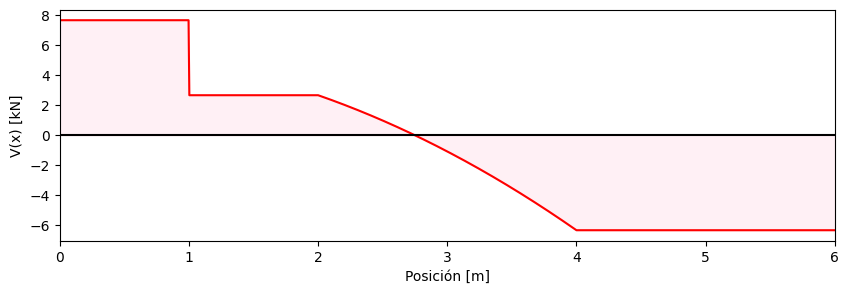

In [18]:
grafico_funcion_viga(xg, V(xg), "V(x) [kN]")

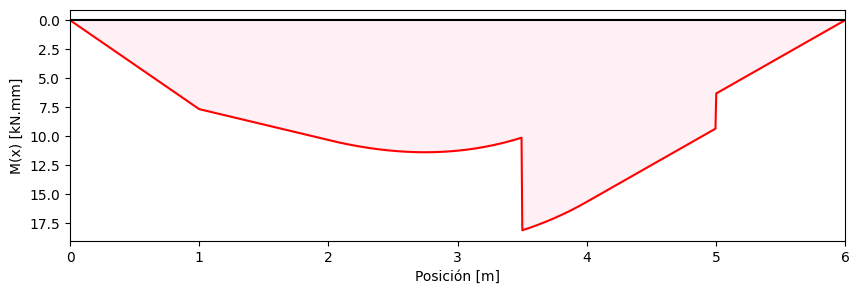

In [19]:
grafico_funcion_viga(xg, M(xg), "M(x) [kN.mm]", momento=True)

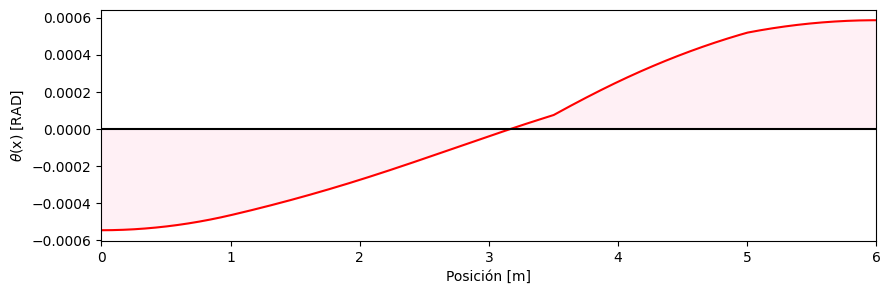

In [20]:
grafico_funcion_viga(xg, t(xg), r"$\theta$(x) [RAD]")

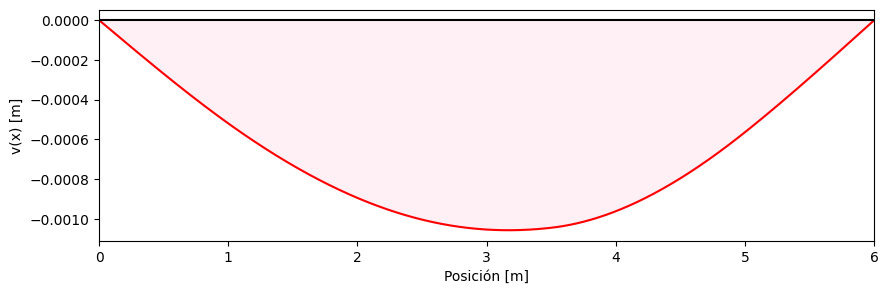

In [21]:
grafico_funcion_viga(xg, v(xg), "v(x) [m]")

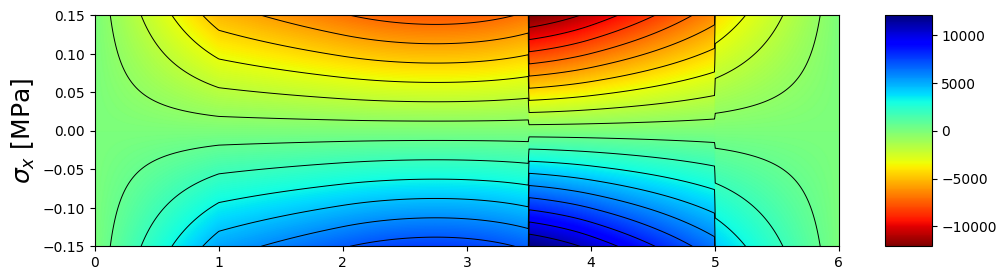

In [22]:
dibujar_esf_def(r"$\sigma_x$ [MPa]", sx(xi,yi), xi, yi)

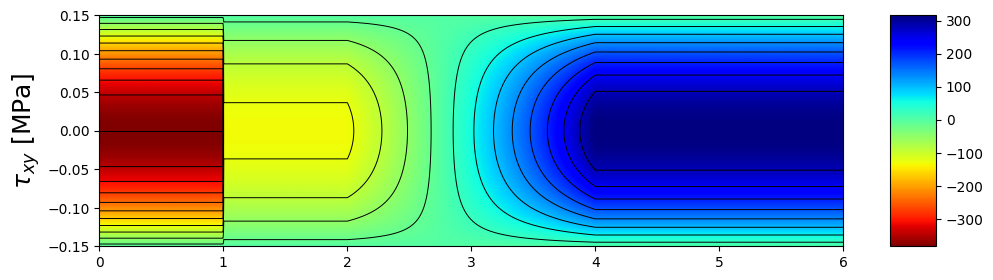

In [23]:
dibujar_esf_def(r"$\tau_{xy}$ [MPa]", txy(xi,yi), xi, yi)

In [24]:
x_Vmax = xg[argmax(V(xg))]
x_Vmin = xg[argmin(V(xg))] # Es mínima de 4.5 hasta 6.
print(f"La fuerza cortante máxima positiva es {round(max(V(xg)),2)}N en la posición x={round(x_Vmax,1)}")
print(f"La fuerza cortante máxima negativa es {round(min(V(xg)),2)}N en la posición x={round(x_Vmin,1)}")

La fuerza cortante máxima positiva es 7.67N en la posición x=0.0
La fuerza cortante máxima negativa es -6.33N en la posición x=4.5


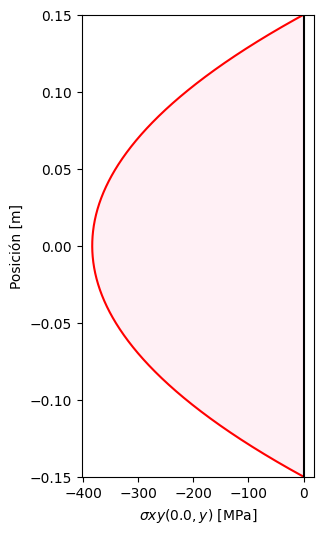

In [25]:
grafico_funcion_esfuerzo_seccion(yg, txy(x_Vmax,yg), rf"$\sigma xy({round(x_Vmax,2)},y)$ [MPa]")

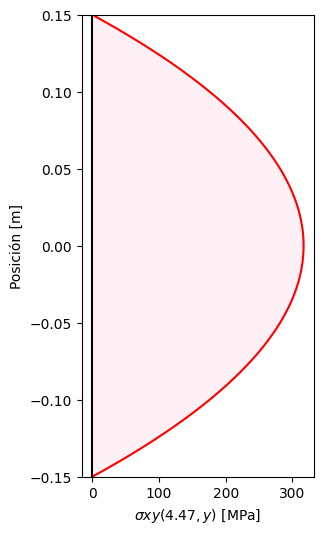

In [26]:
grafico_funcion_esfuerzo_seccion(yg, txy(x_Vmin,yg), rf"$\sigma xy({round(x_Vmin,2)},y)$ [MPa]")

In [27]:
print(f"El esfuerzo cortante máximo positivo es {round(txy(x_Vmin, 0),2)}MPa en la posición x={round(x_Vmin,1)}")
print(f"El esfuerzo cortante máximo negativo es {round(txy(x_Vmax, 0),2)}MPa en la posición x={round(x_Vmax,1)}")

El esfuerzo cortante máximo positivo es 316.67MPa en la posición x=4.5
El esfuerzo cortante máximo negativo es -383.33MPa en la posición x=0.0


In [28]:
x_Mmax = xg[argmax(M(xg))]
print(f"La momento flector máximo positivo es {round(max(M(xg)),2)}N en la posición x={round(x_Mmax,1)}")

La momento flector máximo positivo es 18.11N en la posición x=3.5


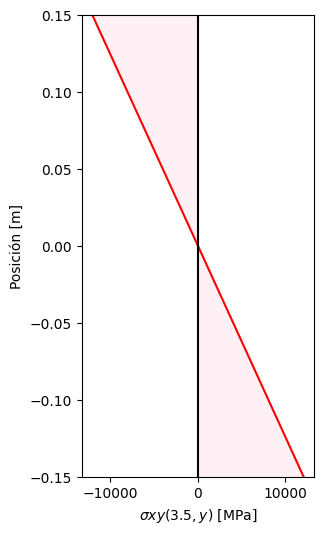

In [29]:
grafico_funcion_esfuerzo_seccion(yg, sx(x_Mmax,yg), rf"$\sigma xy({round(x_Mmax,2)},y)$ [MPa]")

In [30]:
print(f"El esfuerzo normal máximo a tracción es {abs(round(sx(x_Mmax, -ci),2))}MPa en la posición x={round(x_Mmax,1)}")
print(f"El esfuerzo normal máximo a compresión es {abs(round(sx(x_Mmax, cs),2))}MPa en la posición x={round(x_Mmax,1)}")

El esfuerzo normal máximo a tracción es 12072.86MPa en la posición x=3.5
El esfuerzo normal máximo a compresión es 12072.86MPa en la posición x=3.5


In [31]:
x_vmin = xg[argmin(v(xg))]
print(f"El desplazamiento máximo negativo es {round(min(v(xg))*1000,2)}mm en la posición x={round(x_vmin,1)}")

El desplazamiento máximo negativo es -1.06mm en la posición x=3.2
